In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from configs.ve import cifar10_ncsnpp_continuous as configs
from sde_lib import VESDE
from models import ncsnpp
from env import RK45Env
import models.utils as mutils
import torch
import numpy as np
import sampling
import datasets
from utils import restore_checkpoint
from models.ema import ExponentialMovingAverage
from losses import get_optimizer

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=64, 
    device=torch.device("cuda"), 
    use_opt=True, 
    compute_opt=False
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.18815378844738007 1.0
0.18815378844738007 1.0
0.1907317042350769 0.9988287687301636
0.1907317042350769 0.9988287687301636
0.19550678133964539 0.9966407418251038
0.19550678133964539 0.9966407418251038
0.19934335350990295 0.994961142539978
0.19934335350990295 0.994961142539978
0.21720394492149353 0.986562967300415
0.21720394492149353 0.986562967300415
0.2195933759212494 0.985069990158081
0.2195933759212494 0.985069990158081
0.22307507693767548 0.9832037687301636
0.22307507693767548 0.9832037687301636
0.2242163121700287 0.9832037687301636
0.2242163121700287 0.9832037687301636
nfev: 8.0, done: 0
0.23205184936523438 0.9792385101318359
0.23205184936523438 0.9792385101318359
0.23556843400001526 0.9772558808326721
0.23556843400001526 0.9772558808326721
0.2537667453289032 0.9673429131507874
0.2537667453289032 0.9673429131507874
0.25782692432403564 0.9655805826187134
0.25782692432403564 0.9655805826187134
0.26160356402397156 0.9633777141571045
0.26160356402397156 0.9633777141571045
0.260131776

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09411013..1.032563].


nfev: 254.0, done: 64


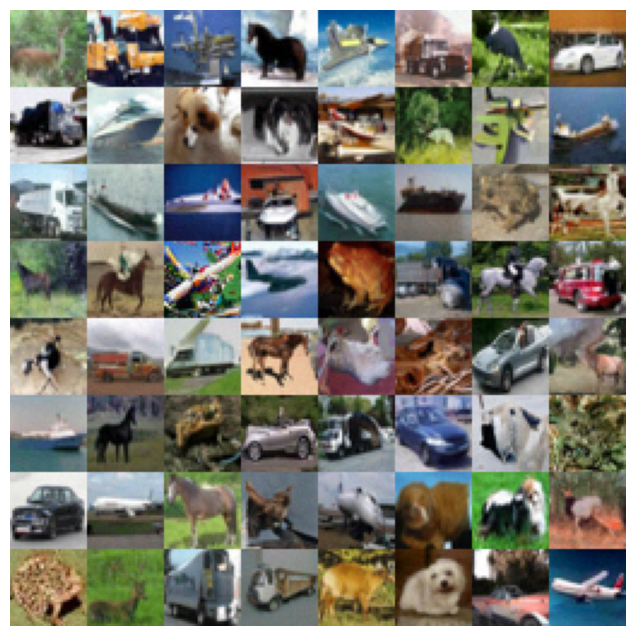

In [5]:
samples = env.sample()
show_samples(samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012918511..1.0139968].


170


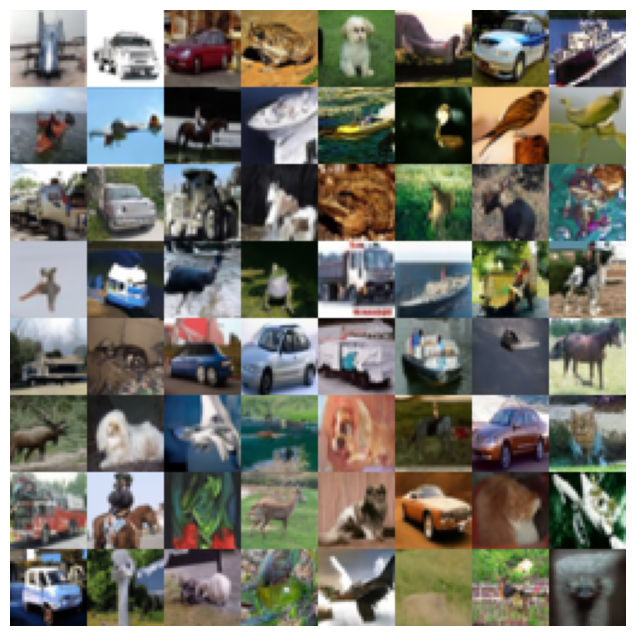

In [6]:
shape = (64, 3, 32, 32)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
print(nfe)
show_samples(x)